In [1]:
# !pip install wordcloud
# !pip install gensim
# !pip install spacy

In [2]:
# references
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
# https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [1]:
# Importing modules
import pandas as pd
import os

# LDA Model
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import spacy

# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

#plotting libraries!
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import the wordcloud library
from wordcloud import WordCloud

# Visualize the topics
import pyLDAvis.gensim
import pickle 
import pyLDAvis


In [2]:
# Read data into questions
df = pd.read_csv('../data/SQuAD_csv.csv', encoding='utf-8').loc[:, ['context']]
df = df.drop_duplicates(subset=['context'])
df.head()

,context
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
15,Following the disbandment of Destiny's Child i...
27,"A self-described ""modern-day feminist"", Beyonc..."
39,"Beyoncé Giselle Knowles was born in Houston, T..."
52,Beyoncé attended St. Mary's Elementary School ...


In [3]:
df.shape

(18877, 1)

## Data Cleaning


#### Text Pre-Processing
We have use gen-sim simple preprocess util to 
(1) Tokenize the textual data.
(2) convert to list of lowercase tokens
(3) deacc = True removes punctuation


In [4]:
import gensim 

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations and special characters

data_words = list(sent_to_words(df['context']))

In [5]:
print(data_words[:3])

[['beyonce', 'giselle', 'knowles', 'carter', 'biːˈjɒnseɪ', 'bee', 'yon', 'say', 'born', 'september', 'is', 'an', 'american', 'singer', 'songwriter', 'record', 'producer', 'and', 'actress', 'born', 'and', 'raised', 'in', 'houston', 'texas', 'she', 'performed', 'in', 'various', 'singing', 'and', 'dancing', 'competitions', 'as', 'child', 'and', 'rose', 'to', 'fame', 'in', 'the', 'late', 'as', 'lead', 'singer', 'of', 'girl', 'group', 'destiny', 'child', 'managed', 'by', 'her', 'father', 'mathew', 'knowles', 'the', 'group', 'became', 'one', 'of', 'the', 'world', 'best', 'selling', 'girl', 'groups', 'of', 'all', 'time', 'their', 'hiatus', 'saw', 'the', 'release', 'of', 'beyonce', 'debut', 'album', 'dangerously', 'in', 'love', 'which', 'established', 'her', 'as', 'solo', 'artist', 'worldwide', 'earned', 'five', 'grammy', 'awards', 'and', 'featured', 'the', 'billboard', 'hot', 'number', 'one', 'singles', 'crazy', 'in', 'love', 'and', 'baby', 'boy'], ['following', 'the', 'disbandment', 'of', 'd

## Removal of stopwords

In [6]:
stop_words = stopwords.words('english')
# stop_words.extend(['sexual', 'harassment','harassed' 'women', 'violence', 'rape', 'raping', 'raped', 'aimforzerosg', '16dayssg','singapore', 'metoo', 'monicabaey', 'assault', 'misconduct', 'violence', 'voyeurism', 'go', 'take', 'make', 'case', 'voyeuristic' ])
# print(stop_words)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


## Phrase Modelling for Bi-grams

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

## Lemmatization

In [8]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['say', 'bear', 'record', 'producer', 'actress', 'bear', 'raise', 'perform', 'various', 'singing', 'dancing', 'competition', 'child', 'rise', 'fame', 'late', 'manage', 'group', 'become', 'world', 'best_selle', 'girl', 'group', 'time', 'see', 'release', 'dangerously', 'love', 'establish', 'worldwide', 'earn', 'feature', 'number', 'single', 'crazy', 'love', 'baby', 'boy']]


In [10]:
print(data_words_bigrams[:3])

[['beyonce', 'giselle', 'knowles', 'carter', 'biːˈjɒnseɪ', 'bee', 'yon', 'say', 'born', 'september', 'american', 'singer_songwriter', 'record', 'producer', 'actress', 'born', 'raised', 'houston', 'texas', 'performed', 'various', 'singing', 'dancing', 'competitions', 'child', 'rose', 'fame', 'late', 'lead_singer', 'girl', 'group', 'destiny_child', 'managed', 'father', 'mathew', 'knowles', 'group', 'became', 'one', 'world', 'best_selling', 'girl', 'groups', 'time', 'hiatus', 'saw', 'release', 'beyonce', 'debut_album', 'dangerously', 'love', 'established', 'solo_artist', 'worldwide', 'earned', 'five', 'grammy_awards', 'featured', 'billboard_hot', 'number', 'one', 'singles', 'crazy', 'love', 'baby', 'boy'], ['following', 'disbandment', 'destiny_child', 'june', 'released', 'second', 'solo', 'album', 'day', 'contained', 'hits', 'deja', 'vu', 'irreplaceable', 'beautiful', 'liar', 'beyonce', 'also', 'ventured', 'acting', 'golden_globe', 'nominated', 'performance', 'dreamgirls', 'starring', 'ro

# Exploratory Data Analysis

## Creating word cloud

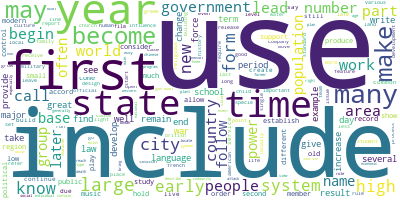

In [11]:
# Import the wordcloud library
from wordcloud import WordCloud
import itertools

# Join the different processed titles together
list_of_words = list(itertools.chain.from_iterable(data_lemmatized))
long_string = ','.join(word for word in list_of_words)
long_string

# # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', collocations = False,  random_state=1)

# # Generate a word cloud
wordcloud.generate(long_string)

# # Visualize the word cloud
wordcloud.to_image()

## Data Transformation: Corpus and Dictionary
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.

Ref: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])
# print(id2word[:10])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(11, 1), (24, 1), (25, 2), (28, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1)], [(4, 1), (18, 1), (24, 2), (31, 2), (38, 1), (40, 1), (41, 1), (60, 2), (61, 1), (64, 1), (74, 2), (79, 1), (83, 1), (84, 4), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1

## Base Model

In [13]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=0,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.016*"use" + 0.012*"include" + 0.011*"also" + 0.009*"design" + '
  '0.009*"window" + 0.009*"bird" + 0.009*"portuguese" + 0.008*"system" + '
  '0.007*"video" + 0.006*"elevator"'),
 (1,
  '0.023*"use" + 0.011*"system" + 0.010*"specie" + 0.008*"power" + '
  '0.008*"time" + 0.007*"first" + 0.006*"make" + 0.006*"would" + '
  '0.006*"current" + 0.006*"control"'),
 (2,
  '0.014*"year" + 0.013*"school" + 0.012*"high" + 0.011*"large" + 0.010*"city" '
  '+ 0.010*"student" + 0.009*"country" + 0.009*"public" + 0.009*"also" + '
  '0.008*"increase"'),
 (3,
  '0.010*"work" + 0.010*"use" + 0.008*"language" + 0.008*"write" + '
  '0.007*"term" + 0.007*"church" + 0.007*"also" + 0.006*"greek" + 0.006*"time" '
  '+ 0.006*"word"'),
 (4,
  '0.016*"government" + 0.013*"state" + 0.013*"would" + 0.010*"force" + '
  '0.008*"military" + 0.008*"power" + 0.008*"year" + 0.007*"political" + '
  '0.007*"lead" + 0.007*"take"'),
 (5,
  '0.012*"population" + 0.011*"also" + 0.011*"include" + 0.011*"city" + '
  '0

In [15]:
# Evaluate base model- Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4049050756756902


## Hyperparameter Tuning

In [16]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=0,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [17]:
#iterate over possible number of topics
topic_param = [5,10,15,20,25,30]
coherence_score = []

for k in topic_param:
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(cv)

param_tuning_coherence = pd.DataFrame()
param_tuning_coherence["topic_param"] = topic_param
param_tuning_coherence['coherence_score'] = coherence_score
param_tuning_coherence

,topic_param,coherence_score
0,5,0.427779
1,10,0.407311
2,15,0.431928
3,20,0.405719
4,25,0.461926
5,30,0.434292


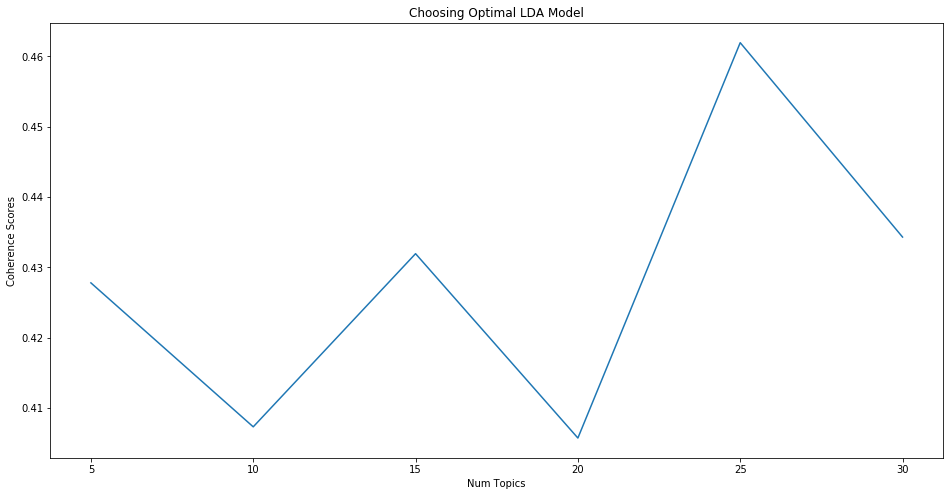

In [18]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, param_tuning_coherence['coherence_score'])

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

## Final Model

In [20]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, 
                                           random_state=0,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [21]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(23,
  '0.000*"pregnancy" + 0.000*"permissive" + 0.000*"heterosexual" + '
  '0.000*"teenage" + 0.000*"sexual_activity" + 0.000*"booklet" + '
  '0.000*"miraculously" + 0.000*"sanctity" + 0.000*"haskalah" + '
  '0.000*"halakhic"'),
 (16,
  '0.000*"interpreting" + 0.000*"scarf" + 0.000*"miraculously" + '
  '0.000*"halakhic" + 0.000*"booklet" + 0.000*"sinai" + 0.000*"rabbis" + '
  '0.000*"pentateuch" + 0.000*"sanctity" + 0.000*"creativity"'),
 (17,
  '0.023*"color" + 0.013*"red" + 0.013*"green" + 0.010*"wear" + 0.007*"blue" + '
  '0.003*"clothing" + 0.003*"yellow" + 0.003*"purple" + 0.002*"carpet" + '
  '0.002*"white"'),
 (1,
  '0.015*"force" + 0.012*"war" + 0.012*"attack" + 0.007*"military" + '
  '0.007*"japanese" + 0.006*"troop" + 0.006*"battle" + 0.005*"operation" + '
  '0.005*"aircraft" + 0.005*"german"'),
 (12,
  '0.010*"use" + 0.006*"group" + 0.006*"also" + 0.005*"work" + 0.005*"study" + '
  '0.005*"time" + 0.005*"human" + 0.005*"write" + 0.004*"may" + 0.004*"term"'),
 (5,
  '0.012*

## Document Topic Matrix

In [22]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))   
  
  

In [23]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(df)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
df['Doc'] = doc_num
df['Topic'] = topic_num
df['Probability'] = prob
df.to_csv("doc_topic_matrix.csv", index=False)

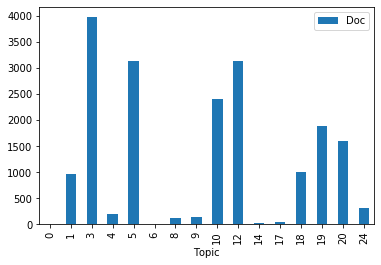

In [24]:
#Number of docs per topic
df_visual = df[['Topic','Doc']].groupby('Topic').agg('count')
df_visual
df_visual.plot.bar()

## Visualize Topics

In [25]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', sort_topics=False)
LDAvis_prepared

C:\Users\Xuesi\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.068652  0.025361       1        1   0.022114
1      0.052035  0.210598       2        1   5.423683
2     -0.068652  0.025361       3        1   0.022114
3      0.262460  0.096516       4        1  18.922367
4     -0.083149 -0.084337       5        1   1.166874
5      0.294964 -0.019960       6        1  14.198917
6     -0.068654  0.025362       7        1   0.022784
7     -0.068652  0.025361       8        1   0.022114
8     -0.156792  0.059826       9        1   1.316031
9     -0.019469 -0.005024      10        1   1.044108
10     0.133838 -0.249290      11        1  11.878005
11    -0.068652  0.025361      12        1   0.022114
12     0.234580 -0.144969      13        1  18.197042
13    -0.068652  0.025361      14        1   0.022114
14    -0.077253  0.024141      15        1   0.212544
15    -0.068652  0.025361      16        1   0.022114
16    -0.068652  0.025361      17        1   0.022114
17    -0.074450  0.060053      18        1   0.391370
18     0.123966  0.125861      19        1   5.325325
19     0.202414 -0.085366      20        1  11.799039
20     0.042373 -0.168349      21        1   7.696646
21    -0.068652  0.025361      22        1   0.022114
22    -0.068652  0.025361      23        1   0.022114
23    -0.068652  0.025361      24        1   0.022114
24    -0.180344 -0.098668      25        1   2.184132, topic_info=     Category         Freq      Term        Total  loglift  logprob
467   Default  2185.000000      city  2185.000000  30.0000  30.0000
325   Default  4857.000000       use  4857.000000  29.0000  29.0000
186   Default  1229.000000     force  1229.000000  28.0000  28.0000
776   Default   536.000000  language   536.000000  27.0000  27.0000
83    Default  2761.000000      year  2761.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
54    Topic25    74.802094   include  3853.457764  -0.1179  -5.5122
2465  Topic25    47.808502   protect   305.485657   1.9693  -5.9598
2372  Topic25    46.985241    common   844.060608   0.9356  -5.9772
485   Topic25    45.165615      many  2856.087158  -0.3229  -6.0167
1140  Topic25    42.567627     human   915.673035   0.7554  -6.0759

[1496 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4547      2  0.041624  accent
4547      4  0.041624  accent
4547      6  0.041624  accent
4547     10  0.665984  accent
4547     11  0.041624  accent
...     ...       ...     ...
3600     13  0.005215    zone
3600     19  0.020860    zone
3600     20  0.057366    zone
3600     21  0.005215    zone
3600     25  0.005215    zone

[7206 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

## Assign topic to user query

In [26]:
#Given a question, find the closest context

def assign_topic(test_data):
    test_words = list(sent_to_words([test_data]))
    test_words = remove_stopwords(test_words)
    test_words_bigrams = make_bigrams(test_words)
    test_data_lemmatized = lemmatization(test_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    test_id2word = corpora.Dictionary(test_data_lemmatized)

    # Create Corpus
    test_texts = test_data_lemmatized

    # Term Document Frequency
    test_corpus = [id2word.doc2bow(text) for text in test_texts]

    new_topics = lda_model[test_corpus]
    
    output_topics = []
    for topic in new_topics:
          output_topics += topic
    return output_topics

## Qualitative Evaluation

Here, we evaluate if the assigned topic for the user query matches the assigned topic for the context. Out of 4 test data, only one was correct.

Context: Beyonce Giselle Knowles-Carter (/biËËˆjÉ’nseÉª/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of BeyoncÃ©'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".

In [33]:
# The correct context was found in Topic 20
test_data = "When did Beyonce start becoming popular?"
output = assign_topic(test_data)
print(output)

[(20, 0.9435172)]


context: In 2004, a large share of natural gas reserves in Iran were untapped. The addition of new hydroelectric stations and the streamlining of conventional coal and oil-fired stations increased installed capacity to 33,000 megawatts. Of that amount, about 75% was based on natural gas, 18% on oil, and 7% on hydroelectric power. In 2004, Iran opened its first wind-powered and geothermal plants, and the first solar thermal plant is to come online in 2009. Iran is the third country in the world to have developed GTL technology.

In [37]:
# the actual context was NOT found in topic 10!
test_data = "How much of Iran's 33k megawatt installed capacity was based on natural gas?"
output = assign_topic(test_data)
print(output)

[(19, 0.95419353)]


Context: Although the drafts of both the Maastricht treaty and the Treaty establishing a Constitution for Europe mentioned federalism, the representatives of the member countries (all of whom would have had to agree to use of the term) never formally adopted it. The strongest advocates of European federalism have been Germany, Italy, Belgium and Luxembourg while those historically most strongly opposed have been the United Kingdom, Denmark and France (with conservative presidents and governments). Since the presidency of FranÃ§ois Mitterrand (1981-1995), the French authorities have adopted a much more pro-European Unification position, as they consider that a strong EU is presenting the best "insurance" against a unified Germany which might become too strong and thus a threat for its neighbours.

In [35]:
# the actual context was found in topic 3
test_data = "When did the French authorities adopted the pro-European Unification position? "
output = assign_topic(test_data)
print(output)

[(3, 0.96687704)]


Context: In theism, God is the creator and sustainer of the universe, while in deism, God is the creator, but not the sustainer, of the universe. Monotheism is the belief in the existence of one God or in the oneness of God. In pantheism, God is the universe itself. In atheism, God is not believed to exist, while God is deemed unknown or unknowable within the context of agnosticism. God has also been conceived as being incorporeal (immaterial), a personal being, the source of all moral obligation, and the "greatest conceivable existent". Many notable philosophers have developed arguments for and against the existence of God.

In [36]:
# the actual context was found in topic 12
test_data = "What does deism believe God's role in the universe is? "
output = assign_topic(test_data)
print(output)

[(12, 0.807987)]


### Deploying Model

In [30]:
import joblib
filename = "LDAmodel.sav"
joblib.dump(lda_model, filename)

['LDAmodel.sav']

In [38]:
#load model
model = joblib.load("LDAmodel.sav")
def assign_topic(test_data):
    test_words = list(sent_to_words([test_data]))
    test_words = remove_stopwords(test_words)
    test_words_bigrams = make_bigrams(test_words)
    test_data_lemmatized = lemmatization(test_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    test_id2word = corpora.Dictionary(test_data_lemmatized)

    # Create Corpus
    test_texts = test_data_lemmatized

    # Term Document Frequency
    test_corpus = [id2word.doc2bow(text) for text in test_texts]

    new_topics = model[test_corpus]
    
    output_topics = []
    for topic in new_topics:
          output_topics += topic
    return output_topics

In [40]:
# The correct context was found in Topic 20
test_data = "When did Beyonce start becoming popular?"
output = assign_topic(test_data)
print(output)

[(20, 0.9435172)]
